In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy

import torch_geometric as pygeom
import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.nn import global_max_pool, global_mean_pool
from torch_geometric.loader import DataLoader, NeighborLoader, RandomNodeLoader
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain.metric import groundtruth_metrics

import lightning.pytorch as pl

from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.colors as mcolors
from typing import Optional, Union, Any
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

## Datasets

### Node classification: BA-Shapes

In [3]:
trans = pygeom.transforms.Compose([T.Constant(), ])

node_dataset = ExplainerDataset(
    graph_generator=pygeom.datasets.graph_generator.BAGraph(num_nodes=300, num_edges=5),
    motif_generator='house',
    num_motifs=80,
    transform=trans,
)

In [4]:
node_dataset

ExplainerDataset(1, graph_generator=BAGraph(num_nodes=300, num_edges=5), motif_generator=HouseMotif(), num_motifs=80)

In [5]:
g = node_dataset[0]

In [6]:
g

Explanation(edge_index=[2, 3958], y=[700], edge_mask=[3958], node_mask=[700], x=[700, 1])

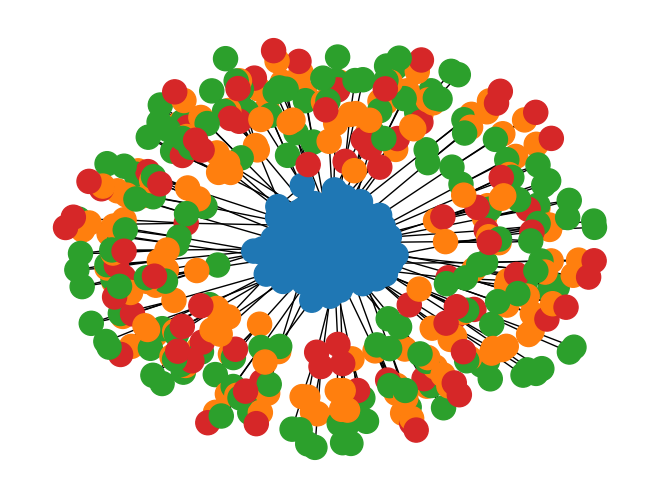

In [7]:
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
        node_color=[colors[i % len(colors)] for i in g.y])

In [8]:
train_idx, val_test_idx =  train_test_split(torch.arange(g.num_nodes), stratify=g.y, train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, stratify=g.y[val_test_idx], train_size=0.5)

In [9]:
data_loader = DataLoader(node_dataset, batch_size=1, shuffle=False)
node_dataloader = {"train": data_loader,
                   "val": data_loader,
                   "test": data_loader}
node_idx = {"train": train_idx,
            "val": val_idx,
            "test": test_idx}

### Graph classification: MUTAG

In [10]:
trans = T.Compose([T.OneHotDegree(10),])

graph_dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True, transform=trans)

In [11]:
graph_dataset

MUTAG(135)

In [12]:
graph_dataset[0]

Data(edge_index=[2, 38], x=[17, 18], edge_attr=[38, 4], y=[1])

In [13]:
train_idx, val_test_idx =  train_test_split(torch.arange(len(graph_dataset)), stratify=torch.tensor([g.y for g in graph_dataset]), train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, stratify=torch.tensor([g.y for g in graph_dataset[val_test_idx]]), train_size=0.5)

In [14]:
train_dataset = graph_dataset[train_idx]
val_dataset = graph_dataset[val_idx]
test_dataset = graph_dataset[test_idx]
print(len(train_dataset), len(val_dataset), len(test_dataset))

108 13 14


In [15]:
batch_size = 8
graph_dataloader = {"train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
                    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
                    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)}

## GNN models

### Node Classification

In [286]:
class NodeGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for node classification.
    """
    def __init__(self, idcs, num_features, num_classes):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(num_features, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, num_classes)
        self.train_idx = idcs["train"]
        self.val_idx = idcs["val"]

    def forward(self, data, edge_weights=None):
        out1 = F.relu(self.gc1(data.x, data.edge_index, edge_weights))
        out2 = F.relu(self.gc2(out1, data.edge_index, edge_weights))
        out3 = F.relu(self.gc3(out2, data.edge_index, edge_weights))
        embedding = out3
        return self.dense(out3), embedding


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, data, _):
        y_pred, _ = self(data)
        loss = F.cross_entropy(y_pred[self.train_idx], data.y[self.train_idx])
        self.log('train_loss', loss, prog_bar=True, batch_size=1)
        return loss

    def validation_step(self, data, _):
        y_hat, _ = self(data)
        self.log('val_accuracy', accuracy(y_hat[self.val_idx].argmax(dim=1), data.y[self.val_idx], task='multiclass', num_classes=4),
            prog_bar=True, batch_size=1)
        self.log('val_loss', F.cross_entropy(y_hat[self.val_idx], data.y[self.val_idx]),
            prog_bar=True, batch_size=1)
        
    def test_step(self, data, _):
        y_hat, _ = self(data)
        self.log('test_accuracy', accuracy(y_hat.argmax(dim=1), data.y, task='multiclass', num_classes=4),
            prog_bar=True, batch_size=1)
        self.log('test_loss', F.cross_entropy(y_hat, data.y),
            prog_bar=True, batch_size=1)

In [287]:
node_gnn = NodeGNN(node_idx, g.x.shape[1], g.y.max().item()+1)

In [288]:
node_gnn(g)

(tensor([[-0.1676,  0.1242, -0.3300, -0.0401],
         [-0.1788,  0.1361, -0.3449, -0.0390],
         [-0.1457,  0.1009, -0.3008, -0.0422],
         ...,
         [-0.1060,  0.0586, -0.2478, -0.0460],
         [-0.1068,  0.0596, -0.2490, -0.0459],
         [-0.1051,  0.0577, -0.2467, -0.0461]], grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.7644, 0.3346,  ..., 0.0000, 0.4493, 0.3590],
         [0.0000, 0.8489, 0.3716,  ..., 0.0000, 0.4989, 0.3987],
         [0.0000, 0.5984, 0.2619,  ..., 0.0000, 0.3517, 0.2810],
         ...,
         [0.0000, 0.2980, 0.1304,  ..., 0.0000, 0.1751, 0.1399],
         [0.0000, 0.3047, 0.1334,  ..., 0.0000, 0.1791, 0.1431],
         [0.0000, 0.2914, 0.1276,  ..., 0.0000, 0.1713, 0.1369]],
        grad_fn=<ReluBackward0>))

In [289]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=5, mode='min')

In [290]:
trainer = pl.Trainer(max_epochs=2000, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [291]:
if os.path.isfile("checkpoints/BA-Shapes/node_gnn.ckpt"):
    trainer.fit(node_gnn, node_dataloader['train'], node_dataloader['val'], ckpt_path="checkpoints/BA-Shapes/node_gnn.ckpt")
else:
    trainer.fit(node_gnn, node_dataloader['train'], node_dataloader['val'])

Restoring states from the checkpoint path at checkpoints/BA-Shapes/node_gnn.ckpt
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/home/ninjak/Documenti/uni/neural_networks/neural-networks-exam/lightning_logs/version_0/checkpoints' to '/home/ninjak/Documenti/uni/neural_networks/neural-networks-exam/lightning_logs/version_23/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 40    
1 | gc2   | GCNConv | 420   
2 | gc3   | GCNConv | 420   
3 | dense | Linear  | 84    
----------------------------------
964       Trainable params
0         Non-trainable params
964       Total params
0.004     Total esti

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

In [292]:
trainer.test(node_gnn, node_dataloader['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9900000095367432     │
│         test_loss         │   0.048862140625715256    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9900000095367432, 'test_loss': 0.048862140625715256}]

<Axes: xlabel='epoch'>

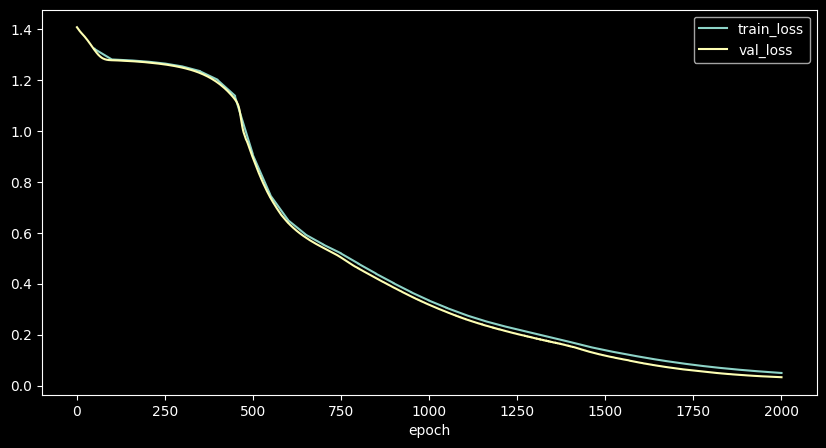

In [293]:
df = pd.read_csv('checkpoints/BA-Shapes/metrics_gnn.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

### Graph Classification

In [294]:
class GraphGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for graph classification.
    """
    def __init__(self, batch_size, num_features, num_classes, lr=1e-3):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(num_features, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, num_classes)
        self.batch_size = batch_size
        self.lr = lr

    def forward(self, batch, edge_weights=None):
        out1 = F.relu(self.gc1(batch.x, batch.edge_index, edge_weights))
        out2 = F.relu(self.gc2(out1, batch.edge_index, edge_weights))
        out3 = F.relu(self.gc3(out2, batch.edge_index, edge_weights))
        embedding = out3
        out = global_max_pool(out3, batch.batch)
        return self.dense(out), embedding


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, _):
        y_pred, _ = self(batch)
        loss = F.binary_cross_entropy_with_logits(y_pred, batch.y.unsqueeze(1).float())
        self.log('train_loss', loss, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, _):
        y_hat, _ = self(batch)
        self.log('val_accuracy', accuracy(y_hat, batch.y.unsqueeze(1).float(), task='binary'),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)
        self.log('val_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)
        
    def test_step(self, batch, _):
        y_hat, _ = self(batch)
        self.log('test_accuracy', accuracy(y_hat, batch.y.unsqueeze(1).float(), task='binary'),
            prog_bar=True, batch_size=self.batch_size)
        self.log('test_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()),
            prog_bar=True, batch_size=self.batch_size)

In [295]:
graph_gnn = GraphGNN(batch_size=graph_dataloader["train"].batch_size,
                     lr=1e-3,
                     num_features=graph_dataset[0].x.shape[1],
                     num_classes=graph_dataset[0].y.shape[0])

In [296]:
graph_gnn(graph_dataset[0])

(tensor([[0.2756]], grad_fn=<AddmmBackward0>),
 tensor([[2.4353e-01, 4.0933e-01, 0.0000e+00, 1.2839e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 7.6902e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 2.2172e-02, 3.5719e-03, 1.0901e-01, 0.0000e+00, 1.0843e-01,
          2.4046e-02, 3.0954e-01],
         [2.3597e-01, 4.0283e-01, 0.0000e+00, 1.2577e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 7.3353e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 2.8354e-02, 2.7428e-04, 1.0937e-01, 0.0000e+00, 1.0905e-01,
          2.4536e-02, 3.0602e-01],
         [2.0107e-01, 3.5845e-01, 0.0000e+00, 1.0434e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 5.1365e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 6.4939e-02, 0.0000e+00, 1.2023e-01, 0.0000e+00, 1.0711e-01,
          2.8186e-02, 2.9046e-01],
         [1.9405e-01, 3.6663e-01, 0.0000e+00, 9.7003e-02, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000

In [297]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=10, mode='min')

In [298]:
trainer = pl.Trainer(max_epochs=1000, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [299]:
if os.path.isfile("checkpoints/MUTAG/graph_gnn.ckpt"):
    trainer.fit(graph_gnn, graph_dataloader['train'], graph_dataloader['val'], ckpt_path="checkpoints/MUTAG/graph_gnn.ckpt")
else:
    trainer.fit(graph_gnn, graph_dataloader['train'], graph_dataloader['val'])

Restoring states from the checkpoint path at checkpoints/MUTAG/graph_gnn.ckpt
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/home/ninjak/Documenti/uni/neural_networks/neural-networks-exam/lightning_logs/version_2/checkpoints' to '/home/ninjak/Documenti/uni/neural_networks/neural-networks-exam/lightning_logs/version_24/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 380   
1 | gc2   | GCNConv | 420   
2 | gc3   | GCNConv | 420   
3 | dense | Linear  | 21    
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimat

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

Epoch 11:  50%|█████     | 7/14 [00:00<00:00, 59.67it/s, v_num=24, train_loss=0.374]

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11: 100%|██████████| 14/14 [00:00<00:00, 53.70it/s, v_num=24, train_loss=0.417, val_accuracy=0.837, val_loss=0.435]


In [300]:
trainer.test(graph_gnn, graph_dataloader['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 63.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │    0.17961280047893524    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 1.0, 'test_loss': 0.17961280047893524}]

<Axes: xlabel='epoch'>

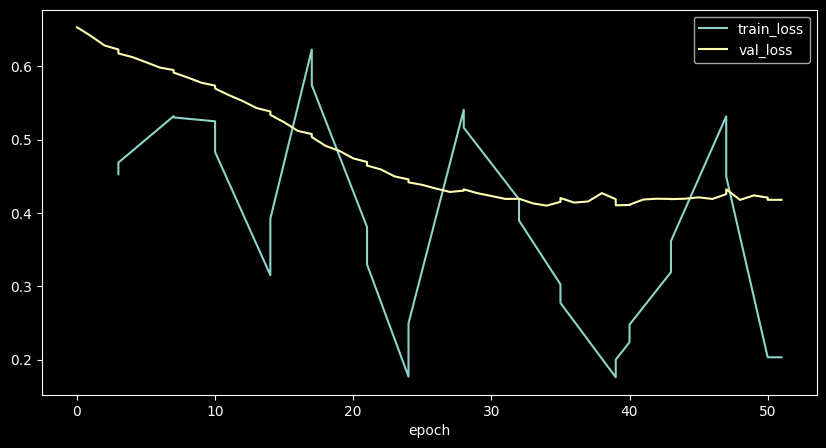

In [301]:
df = pd.read_csv('checkpoints/MUTAG/metrics_gnn.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

## PGExplainer

### Dataset collection

In [302]:
class ExplainerDataModule(pl.LightningDataModule):
    
    def __init__(self, dataset, name, model, mode='node', batch_size=1):
        super().__init__()
        self.dataset = dataset
        self.name = name
        self.model = model.eval()
        self.mode = mode
        self.batch_size = batch_size
        
    def prepare_data(self):
        if self.mode == 'node':
            self.dataset_len = self.dataset.num_nodes
        else:
            self.dataset_len = len(self.dataset)
            
        self.train_idx, self.test_idx = train_test_split(torch.arange(self.dataset_len), shuffle=True, train_size=0.8)
        
    def setup(self, stage=None):
        graphs = []
        self.preproc_dataset = []
        if stage == "fit":
            idcs = self.train_idx
        elif stage == "test":
            idcs = self.test_idx
        elif stage == "predict":
            idcs = torch.randint(0, self.dataset_len, (5,))
            
        if self.mode == "node":
            for idx in idcs:
                graph = self.dataset.clone()
                graph.edge_index = k_hop_subgraph(int(idx), 3, self.dataset.edge_index)[1]
                graphs.append((graph, idx))
        else:
            for idx in idcs:
                graph = self.dataset[idx]
                graphs.append((graph, idx))
                
        # y_preds = []
        # zs = []
        # idcs = []
        # gs = []
        for g, idx in graphs:
            y_pred, z = self.model(g)
            explainer_in = self._process_embeddings(g.edge_index, idx, z)
            self.preproc_dataset.append((y_pred, explainer_in, g, idx))
        #     y_preds.append(y_pred)
        #     zs.append(explainer_in)
        #     idcs.append(idx)
        #     gs.append(g)
            
        # self.preproc_dataset = [(y_preds, zs, gs, idcs)]
            
    def _process_embeddings(self, edge_indexes, node_idx, embeddings):  
        """
            This function is readapted from the following implementation:
            https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks/blob/main/ExplanationEvaluation/explainers/PGExplainer.py
        """
        if self.mode == "node":
            explainer_in = torch.cat([embeddings[edge_indexes[0]],
                                      embeddings[edge_indexes[1]],
                                      embeddings[node_idx].repeat(edge_indexes.shape[1], 1)], dim=1)
        else:
            explainer_in = torch.cat([embeddings[edge_indexes[0]],
                                      embeddings[edge_indexes[1]]], dim=1)
        return explainer_in
                
    def train_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)  
    
    def predict_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)  

In [303]:
node_explainer_module = ExplainerDataModule(g, "BA-Shapes", node_gnn, mode='node', batch_size=1)

In [304]:
graph_explainer_module = ExplainerDataModule(graph_dataset, "MUTAG", graph_gnn, mode='graph', batch_size=1)

### Model definition

In [331]:
class PGExplainer(pl.LightningModule):
    
    def __init__(self, model:pl.LightningModule, lr=3e-3, size_r=0.05, ent_r=1.0, max_epoch=30, temp=(5.0, 2.0), mode='node', *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        if mode == 'node':
            self.mlp = nn.Sequential(
                nn.Linear(60, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        elif mode == 'graph':
            self.mlp = nn.Sequential(
                nn.Linear(40, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        else:
            raise ValueError("mode must be either 'node' or 'graph'")
        
        self.mode = mode
        self.model = model
        self.model.freeze()
        self.lr = lr
        self.temp = temp
        self.max_epoch = max_epoch
        self.size_r = size_r
        self.ent_r = ent_r
        self.automatic_optimization = False
        self.loss = None
        self.curr_temp = None
        
    def _sample_graph(self, om, temp, training=False):
        """ This implementation is readapted from this 
            https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks/blob/main/ExplanationEvaluation/explainers/PGExplainer.py
        """
        if training:
            eps = 1e-4
            eps = (eps - (1 - eps)) * torch.rand_like(om) + (1 - eps)
            uniform = torch.log(eps) - torch.log(1 - eps)
            uniform = (uniform + om) / temp
            edge_mask = torch.sigmoid(uniform)
        else:
            edge_mask = torch.sigmoid(om)
        return edge_mask
    
    def _loss(self, y0, ys, edge_mask):
        loss = F.cross_entropy(ys, y0.argmax(dim=-1))
        
        size_constraint = torch.sum(edge_mask) * self.size_r
        mask = 0.99 * edge_mask + 0.005
        ent_constraint = -mask * torch.log(mask) - (1 - mask) * torch.log(1 - mask)
        ent_constraint = torch.mean(ent_constraint) * self.ent_r
        
        return loss + size_constraint + ent_constraint
        
    def forward(self, z):
        om = self.mlp(z)
        return om
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def training_step(self, data, batch_idx):
        opt = self.optimizers()    
        # y0s, zs, g0s, idcs = data
        if batch_idx == 0:
            opt.zero_grad()
            self.loss = torch.zeros(1, dtype=torch.float, device=self.device).detach()
            self.curr_temp = self.temp[0] * (self.temp[1] / self.temp[0]) ** self.current_epoch
        # for y0, z, g0, idx in zip(y0s, zs, g0s, idcs):
        y0, z, g0, idx = data
        
        idx = int(idx)
        om = self(z.detach())
        edge_mask = self._sample_graph(om, self.curr_temp, training=True).squeeze()
        ys, _ = self.model(g0, edge_mask)
        ys = ys.unsqueeze(0)
        if self.mode == 'node':
            ys = ys[:, idx].squeeze(1)
            y0 = y0[:, idx].squeeze(1)
            
        idx_loss = self._loss(y0, ys, edge_mask)
        self.loss += idx_loss
            
        if batch_idx == self.trainer.num_training_batches - 1:
            self.log('mean_idx_loss', self.loss/self.trainer.num_training_batches, prog_bar=True, batch_size=1)
            self.log('train_loss', self.loss, prog_bar=True, on_step=False, on_epoch=True)
            self.manual_backward(self.loss)
            opt.step()
            
    def test_step(self, batch, _):
        om = self(batch)
        y0, _, g0, idx = batch
        temp = self.temp[0] * (self.temp[1] / self.temp[0]) ** self.current_epoch
        edge_mask = self._sample_graph(om, temp, training=True).squeeze()
        
        ys, _ = self.model(g0, edge_mask)
        ys = ys.unsqueeze(0)
        if self.mode == 'node':
            ys = ys[:, idx].squeeze(1)
            y0 = y0[:, idx].squeeze(1)
            
        # groundtruth_metrics(edge_mask, )
            

In [338]:
explainer = PGExplainer(model=node_gnn, mode='node')

In [333]:
trainer = pl.Trainer(max_epochs=30)

trainer.fit(explainer, datamodule=node_explainer_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | mlp   | Sequential | 4.0 K 
1 | model | NodeGNN    | 964   
-------------------------------------
4.0 K     Trainable params
964       Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 560/560 [00:07<00:00, 71.99it/s, v_num=32, mean_idx_loss=4.870, train_loss=2.73e+3] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 560/560 [00:07<00:00, 71.94it/s, v_num=32, mean_idx_loss=4.870, train_loss=2.73e+3]


In [334]:
explainer = PGExplainer(graph_gnn, mode='graph')

In [335]:
trainer = pl.Trainer(max_epochs=30)

trainer.fit(explainer, datamodule=graph_explainer_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | mlp   | Sequential | 2.7 K 
1 | model | GraphGNN   | 1.2 K 
-------------------------------------
2.7 K     Trainable params
1.2 K     Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 108/108 [00:01<00:00, 71.96it/s, v_num=33, mean_idx_loss=0.102, train_loss=11.00]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 108/108 [00:01<00:00, 71.62it/s, v_num=33, mean_idx_loss=0.102, train_loss=11.00]
